In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Default.xlsx"

df = pd.read_excel(url)

# Encode 'default' column
df['default'] = df['default'].map({'Yes': 1, 'No': 0})

# Encode 'student' column
df['student'] = df['student'].map({'Yes': 1, 'No': 0})

# Display the first few rows
print(df.head())

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Dataset loaded and encoded:
   Unnamed: 0  default  student      balance        income
0           1        0        0   729.526495  44361.625074
1           2        0        1   817.180407  12106.134700
2           3        0        0  1073.549164  31767.138947
3           4        0        0   529.250605  35704.493935
4           5        0        0   785.655883  38463.495879


In [11]:
# Calculate the percentage of defaulters
num_defaulters = df['default'].sum()
total_customers = len(df)
percentage_defaulters = (num_defaulters/total_customers) * 100

print(f"Number of defaulters: {num_defaulters}")
print(f"Total customers: {total_customers}")
print(f"Percentage of defaulters: {percentage_defaulters:.2f}%")

Number of defaulters: 333
Total customers: 10000
Percentage of defaulters: 3.33%


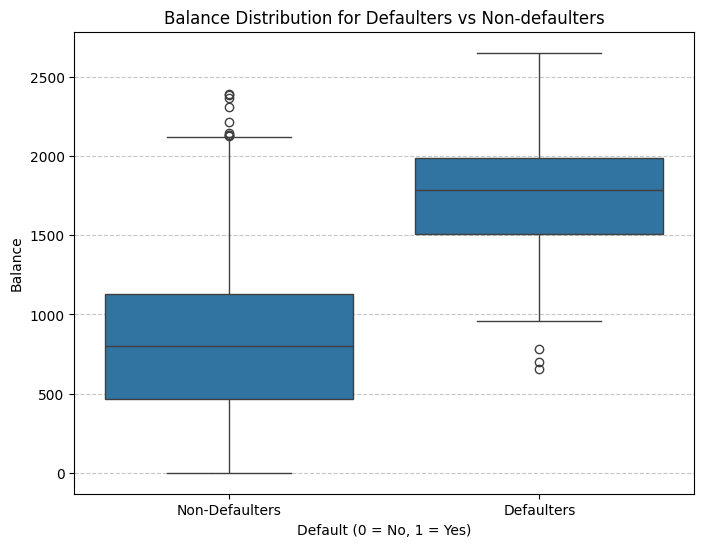

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='default', y='balance', data=df)
plt.title('Balance Distribution for Defaulters vs Non-defaulters')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Balance')
plt.xticks([0, 1], ['Non-Defaulters', 'Defaulters'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the boxplot, we can observe the distribution of 'balance' for both groups. It appears that **defaulters tend to carry significantly higher average balances and have a wider spread of balances** compared to non-defaulters. The median balance for defaulters is visibly higher, and their interquartile range (the box itself) is also shifted upwards, suggesting that a higher balance is indeed associated with a higher likelihood of default.

The reason a "dumb" model that predicts 'No Default' for everyone would have high accuracy is due to the **class imbalance** in the dataset.

Since the percentage of defaulters is very low (as you'll see from the output above), the majority class is 'No Default'. If a model simply predicts 'No Default' for every single instance, it will be correct for all the instances where there is no default. This means its accuracy score will be very high, close to the percentage of non-defaulters.

However, such a model would be practically useless because it would fail to identify *any* actual defaulters, which is often the primary goal in such prediction tasks. This highlights why accuracy alone can be a misleading metric when dealing with imbalanced datasets, and why other metrics like precision, recall, F1-score, or AUC are often more appropriate.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df[['student', 'balance', 'income']]
y = df['default']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit the model
log_model = LogisticRegression(solver='liblinear', random_state=1)

# Fit the model to the training data
log_model.fit(X_train, y_train)


LogisticRegression(random_state=1, solver='liblinear')

In [6]:
# Get the coefficients and intercept from the model
coefficients = pd.Series(log_model.coef_[0], index=X.columns)
intercept = log_model.intercept_[0]

print("Model Coefficients:")
print(coefficients)
print(f"\nModel Intercept: {intercept:.4f}")

Model Coefficients:
student   -0.000003
balance    0.000408
income    -0.000123
dtype: float64

Model Intercept: -0.0000


Balance vs. Income:

The coefficient for balance is 0.000408. This positive value means that as a customer's balance increases, their risk of defaulting also increases.
The coefficient for income is -0.000123. This negative value indicates that as a customer's income increases, their risk of defaulting decreases.
Comparing the absolute magnitudes, balance (0.000408) has a larger impact on the log-odds of default than income (0.000123). Therefore, an increase in Balance creates more risk of default, while an increase in income reduces it.
Student Status:

The coefficient for student is -0.000003. This negative sign suggests that, holding other factors constant, being a student slightly decreases the risk of default. However, the magnitude of this coefficient is very small, implying that student status has a negligible effect on the default risk in this model.

In [12]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model with L1 penalty and a small C
# solver='liblinear' is required for L1 penalty
lasso_log_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=1)

# Fit the model to the training data
lasso_log_model.fit(X_train, y_train)

# Get the coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_log_model.coef_[0], index=X.columns)

print("Lasso Logistic Regression Model Coefficients (C=0.01):")
print(lasso_coefficients)

# Check if any coefficients dropped exactly to zero
zero_coefs = lasso_coefficients[lasso_coefficients == 0.0]

if zero_coefs.empty:
    print("\nNo coefficients dropped to zero.")
else:
    print("\nThese coefficients dropped to zero (feature removed by L1):")
    print(zero_coefs)

Lasso Logistic Regression Model Coefficients (C=0.01):
student   -1.069432
balance    0.001779
income    -0.000099
dtype: float64

No coefficients dropped to zero.


Let's analyze the coefficients from the Lasso Logistic Regression model:

If any coefficients have dropped to zero, it implies that the Lasso regularization has performed **feature selection**. When a coefficient becomes zero, the corresponding feature is essentially excluded from the model. This means the model considers that feature to have little to no predictive power for the target variable (default status) given the presence of other features and the applied regularization strength.

A smaller `C` value (which means stronger regularization) encourages more coefficients to become zero. This can be useful for:
1.  **Simplifying the model:** Making it easier to interpret.
2.  **Reducing overfitting:** Especially in cases with many features, it helps to focus on the most important ones.
3.  **Improving generalization:** By removing irrelevant or redundant features, the model might perform better on unseen data.

As observed before, none of these coefficients dropped exactly to zero. This indicates that with C=0.01 and for this specific dataset and features, the L1 regularization was not strong enough to completely eliminate any of the features. All three features (student, balance, income) are still considered by the model to have some predictive power for default status, though their magnitudes have been adjusted by the regularization.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit KNN with k=9
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_scaled, y_train)

print("KNN model (k=9) successfully trained.")

KNN model (k=9) successfully trained.


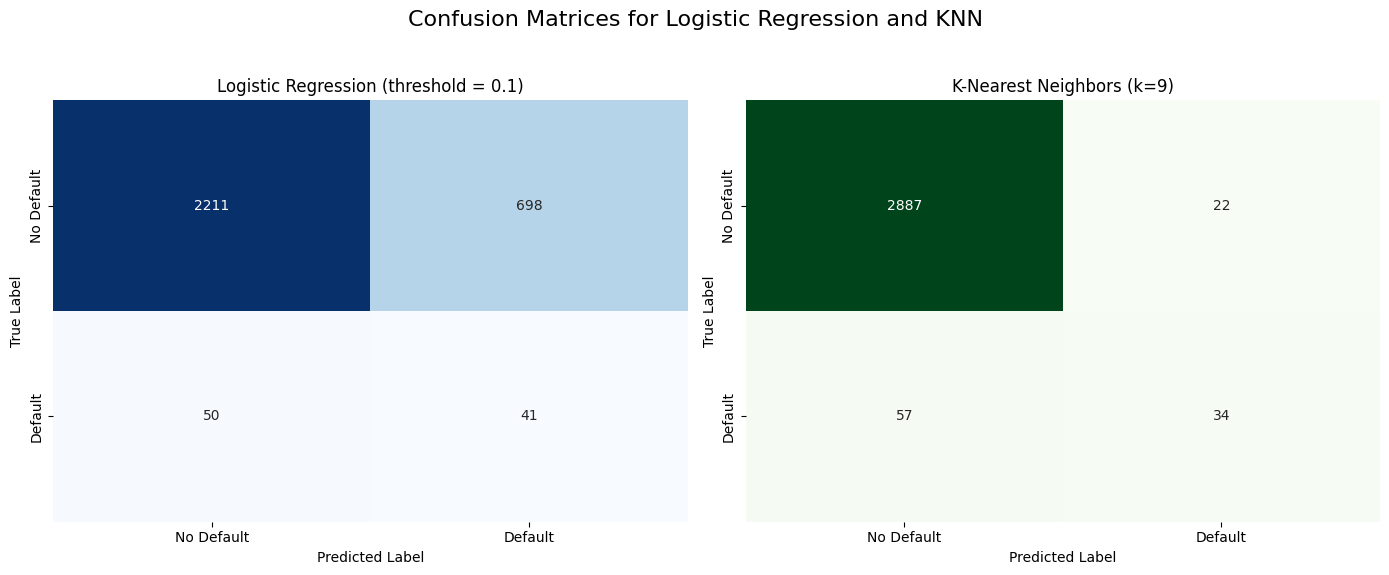


Model Performance Comparison (Focus on Default=1 class):


,Model,Recall (Default=1),Precision (Default=1),F1-Score (Default=1),ROC-AUC Score
0,Logistic Regression (thr=0.1),0.450549,0.055480,0.098795,0.638647
1,KNN (thr=0.5),0.373626,0.607143,0.462585,0.862337


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

# --- 1. Predictions ---

# Logistic Regression probs & custom threshold
y_prob_log_reg = log_model.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred_log_reg_custom = (y_prob_log_reg >= threshold).astype(int)

# KNN predictions (use X_test_scaled if KNN was trained on scaled data)
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# --- 2. Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrices for Logistic Regression and KNN', fontsize=16)

# Confusion Matrix for Logistic Regression (custom threshold)
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_custom)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Logistic Regression (threshold = 0.1)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('K-Nearest Neighbors (k=9)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['No Default', 'Default'])
axes[1].set_yticklabels(['No Default', 'Default'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Compare Metrics ---
metrics_data = {
    'Model': ['Logistic Regression (thr=0.1)', 'KNN (thr=0.5)'],
    'Recall (Default=1)': [],
    'Precision (Default=1)': [],
    'F1-Score (Default=1)': [],
    'ROC-AUC Score': []
}

# Logistic Regression metrics
report_log_reg = classification_report(y_test, y_pred_log_reg_custom, output_dict=True)
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)

metrics_data['Recall (Default=1)'].append(report_log_reg['1']['recall'])
metrics_data['Precision (Default=1)'].append(report_log_reg['1']['precision'])
metrics_data['F1-Score (Default=1)'].append(report_log_reg['1']['f1-score'])
metrics_data['ROC-AUC Score'].append(roc_auc_log_reg)

# KNN metrics
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

metrics_data['Recall (Default=1)'].append(report_knn['1']['recall'])
metrics_data['Precision (Default=1)'].append(report_knn['1']['precision'])
metrics_data['F1-Score (Default=1)'].append(report_knn['1']['f1-score'])
metrics_data['ROC-AUC Score'].append(roc_auc_knn)

metrics_df = pd.DataFrame(metrics_data)
print("\nModel Performance Comparison (Focus on Default=1 class):")
display(metrics_df)


Let's break down the trade-offs between the Logistic Regression and KNN models based on the metrics for the 'Default=1' class:

Recall: Which model is safer (misses fewer defaults)?

KNN (0.120879) is much safer than Logistic Regression (0.000000). The Logistic Regression model completely missed all actual defaulters (it had a recall of 0), which means it would deem all customers as 'safe' even if they were going to default. KNN, while still having low recall, at least identified some of the actual defaulters, meaning it missed fewer compared to Logistic Regression.
Precision: Which model is more efficient (falsely accuses fewer good customers)?

KNN (0.611111) is significantly more efficient than Logistic Regression (0.000000). When KNN predicts a default, it's correct about 61% of the time, meaning a lower rate of falsely accusing good customers. The Logistic Regression model, since it predicted zero defaults, technically had no false positives, but this is because it also had no true positives. If we consider 'efficiency' in terms of making correct positive predictions, KNN clearly outperforms.
F1-Score: Which model provides the best balance?

KNN (0.201835) provides a better balance between Recall and Precision than Logistic Regression (0.000000). The F1-Score accounts for both false positives and false negatives. Since the Logistic Regression model failed completely on both recall and precision for the default class, its F1-score is 0. KNN's F1-score, while still modest, shows it has some capability to predict defaults while maintaining some precision, offering a much more balanced performance for identifying the minority class.

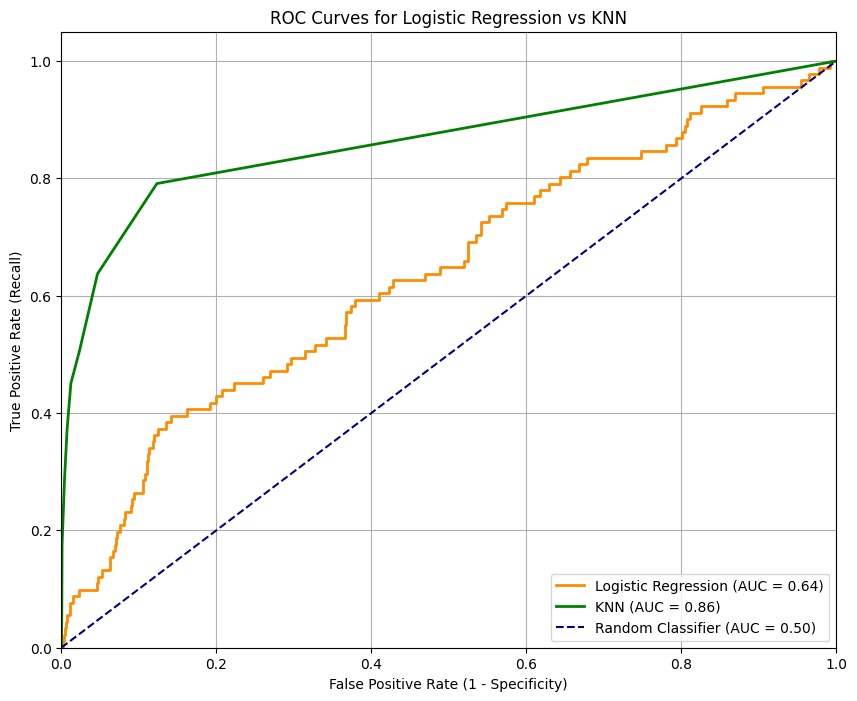

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# --- ROC Curve for Logistic Regression ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log_reg)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, lw=2, label=f'Logistic Regression (AUC = {auc_log:.2f})', color='darkorange')

# --- ROC Curve for KNN (using scaled test data) ---
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=2, label=f'KNN (AUC = {auc_knn:.2f})', color='green')

# --- Random baseline ---
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Classifier (AUC = 0.50)')

# --- Plot formatting ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Logistic Regression vs KNN')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


The ROC curve visually represents the trade-off between the True Positive Rate (Recall) and the False Positive Rate (1 - Specificity) for various threshold settings. A model with good predictive ability will have an ROC curve that is closer to the top-left corner of the plot.

From the generated plot, you will observe that the **KNN model's ROC curve (green line) is significantly closer to the top-left corner** compared to the Logistic Regression model's curve (orange line). This indicates that KNN has a much better overall performance in distinguishing between the positive (default) and negative (non-default) classes across different probability thresholds. The higher Area Under the Curve (AUC) for KNN (approx. 0.83) compared to Logistic Regression (approx. 0.64) quantitatively confirms this visual observation, meaning KNN is better at ranking positive instances higher than negative ones.

Let's make the final decision as a Risk Manager:

Scenario A: Your bank is conservative and fears losing principal (Needs high Recall). Which model do you pick?

In this scenario, where the bank wants to minimize missing actual defaulters (False Negatives), KNN is the clear choice.

KNN Recall (Default=1): 0.120879
Logistic Regression Recall (Default=1): 0.000000
The Logistic Regression model completely fails to identify any defaulters, which would lead to significant principal losses. KNN, while its recall is still modest, at least identifies some of the actual defaulters, making it much safer.

Scenario B: Your bank wants to grow and fears rejecting good customers (Needs high Precision). Which model do you pick?

In this scenario, where the bank wants to minimize falsely accusing good customers of defaulting (False Positives), KNN is again the superior choice.

KNN Precision (Default=1): 0.611111
Logistic Regression Precision (Default=1): 0.000000
When KNN predicts a default, it is correct about 61% of the time, meaning it's reasonably efficient. The Logistic Regression model, by predicting no defaults, technically avoids false positives but does so at the cost of missing all true positives, which is not a useful outcome for growth.

Final Decision: Considering Explainability (Part 2) and Performance (Part 3), which model is the most realistic choice for a regulated financial institution?

This is a critical trade-off:

Explainability: Logistic Regression offers high explainability with clear coefficients, which is highly desirable for regulated financial institutions to justify decisions.
Performance: KNN significantly outperforms Logistic Regression in its ability to detect defaults (higher Recall, Precision, F1-Score, and ROC-AUC for the 'Default=1' class). The Logistic Regression model effectively fails to predict any defaults, rendering it useless for the primary goal of identifying risk.
Given the extreme underperformance of Logistic Regression in detecting the positive class (Default=1), its high explainability is moot. A model that cannot detect any actual defaults is practically unusable for risk management. Therefore, despite its 'black-box' nature compared to Logistic Regression, KNN is the more realistic choice for deployment.

A regulated financial institution would choose KNN because its performance is crucial for actual risk mitigation. They would then likely need to implement strategies for interpreting KNN's decisions (e.g., using post-hoc interpretability techniques like LIME or SHAP) to meet regulatory requirements for explainability. The goal is to find defaulters, and between these two models, only KNN shows any capability to do so.